# Matriz Orígen Destino a partir de los datos de Twitter

In [1]:
%load_ext autoreload
%autoreload 2
import geopandas as gpd
from shapely.geometry import LineString, Point
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob

## Leer los tuits

Para probar y hacer todo más rápido, vamos a usar sólo una muestra de 1M al azar

In [5]:
tuits = gpd.read_file("../data/tuits.shp",colums=['uname', 'fecha_hora', 'geometry'])
tuits.drop(['uname', 'fecha_hora', 'geometry'], axis=1, inplace=True)
tuits = tuits.sample(n=1000000)
tuits.head()

,id,contenido,fecha,hora,intervalo
2804396,6482995,I'm at Museo Franz Mayer - @el_mayer in Cuauht...,2015-01-29,22:42:31,thu.06
4798496,8479454,"🍡🍲🍜 (@ Sushi Roll in Benito Juárez, DF) https:...",2015-03-25,21:22:17,wed.05
5074691,8756044,"#OneDirection ""Steal My Girl"" #XOXO @radiodisney",2015-04-01,21:25:39,wed.05
1641159,1722787,Aay :-(,2014-12-23,10:01:48,tue.02
3340490,7019736,"""Feliz día de San Valentín a todos los enamora...",2015-02-14,20:41:50,sat.05


## Leer las zonas de análisis de la encuesta OD

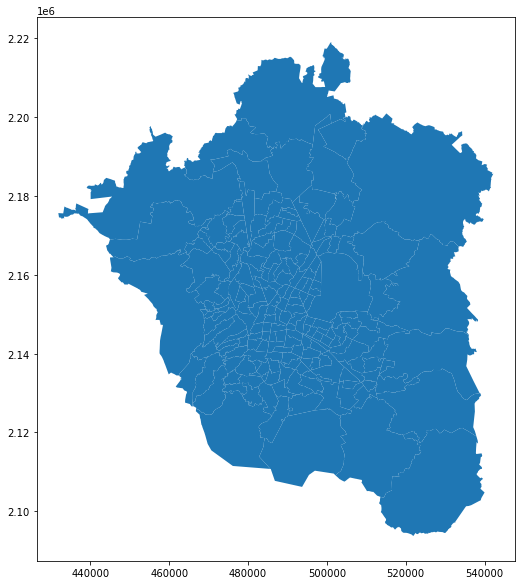

In [101]:
zonas = gpd.read_file("../data/DistritosEODHogaresZMVM2017.shp")
zonas.plot(figsize=(15, 10))

## Unir (y cortar) los tuits con las zonas

In [102]:
tuits = tuits.to_crs("EPSG:32614")
tuits = gpd.sjoin(tuits, zonas)
tuits.head()

,id,uname,contenido,fecha,hora,fecha_hora,intervalo,geometry,index_right,Distrito,Descripcio
1131996,1212327,Rubiroba,Buenas noches México.,2014-12-05,23:50:52,2014-12-05 23:50:52-06,fri.06,POINT (478830.782 2171384.390),111,126,Centro Urbano-CC CuautitlÃ¡n Izcalli
545832,461503,NicteHueleFeo,Jajajaja siempre nos andamos burlando de que y...,2014-11-11,23:11:22,2014-11-11 23:11:22-06,tue.06,POINT (477391.174 2172540.520),111,126,Centro Urbano-CC CuautitlÃ¡n Izcalli
1813179,1895473,coutocz,Y el truco esta en... En el inmenso amor que n...,2014-12-29,22:49:35,2014-12-29 22:49:35-06,mon.06,POINT (477764.654 2173255.556),111,126,Centro Urbano-CC CuautitlÃ¡n Izcalli
3459781,7139196,Alets160796,Llevo 2 meses rogandote y sinceramente ¡YA ME ...,2015-02-18,10:44:26,2015-02-18 10:44:26-06,wed.02,POINT (477276.243 2171444.393),111,126,Centro Urbano-CC CuautitlÃ¡n Izcalli
1426483,1507518,cupuladelibros,"¡Chicos, esta semana les tenemos muchas sorpre...",2014-12-15,21:02:03,2014-12-15 21:02:03-06,mon.05,POINT (477660.642 2171648.180),111,126,Centro Urbano-CC CuautitlÃ¡n Izcalli


Podemos ver las dos capas juntas en el mapa

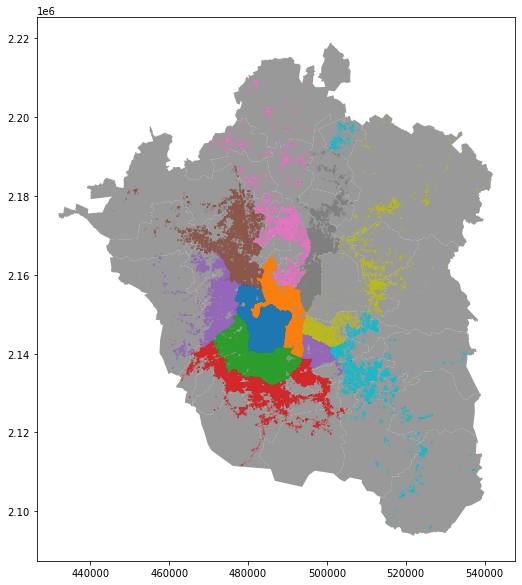

In [103]:
fig , ax = plt.subplots(1, figsize=(15,10))
zonas.plot(ax=ax, facecolor='grey', alpha=0.8)
tuits.plot(ax=ax, column='Distrito', markersize=0.1, alpha=0.5)
plt.show()

## Preproceso

* Cambiar fecha_hora a timestamp
* Ajustar timezone
* Eliminar columnas innecesarias

In [104]:
tuits['fecha_hora_dt'] = pd.to_datetime(tuits['fecha_hora'], format='%Y-%m-%d %H:%M:%S', utc=True)
tuits.fecha_hora_dt = tuits.fecha_hora_dt.dt.tz_convert('America/Mexico_City')
tuits.drop(['contenido', 'fecha', 'hora', 'intervalo', 'fecha_hora'],axis=1, inplace=True)
tuits.head()

,id,uname,geometry,index_right,Distrito,Descripcio,fecha_hora_dt
1131996,1212327,Rubiroba,POINT (478830.782 2171384.390),111,126,Centro Urbano-CC CuautitlÃ¡n Izcalli,2014-12-05 23:50:52-06:00
545832,461503,NicteHueleFeo,POINT (477391.174 2172540.520),111,126,Centro Urbano-CC CuautitlÃ¡n Izcalli,2014-11-11 23:11:22-06:00
1813179,1895473,coutocz,POINT (477764.654 2173255.556),111,126,Centro Urbano-CC CuautitlÃ¡n Izcalli,2014-12-29 22:49:35-06:00
3459781,7139196,Alets160796,POINT (477276.243 2171444.393),111,126,Centro Urbano-CC CuautitlÃ¡n Izcalli,2015-02-18 10:44:26-06:00
1426483,1507518,cupuladelibros,POINT (477660.642 2171648.180),111,126,Centro Urbano-CC CuautitlÃ¡n Izcalli,2014-12-15 21:02:03-06:00


## Obtener las trayectorias

Vamos a agrupar por dia y por intervalos de 3 horas como base temporal para calcular la matriz OD.

Para poder encontrar las trayectorias de los usuarios, necesitamos también agrupar por `uname`

Para entender bien la agrupación, vamos primero a seleccionar un sólo dia


**NOTA:** Hay que separar dias hábiles

### Agrupación de datos

In [116]:
un_dia = (tuits.groupby([pd.Grouper(key='fecha_hora_dt', freq='1D'), 
                pd.Grouper(key='fecha_hora_dt', freq='4H', base=2), 
                'uname'])
       .count().loc['2014-11-26 00:00:00-06:00',:,:])
un_dia.index.names =['dia', 'intervalo', 'uname']
un_dia.head()

id  geometry  \
dia                       intervalo                 uname                      
2014-11-26 00:00:00-06:00 2014-11-25 22:00:00-06:00 0t5          1         1   
                                                    19Arti       1         1   
                                                    19cmBi       1         1   
                                                    87patriots   3         3   
                                                    AAnnaa11     1         1   

                                                                index_right  \
dia                       intervalo                 uname                     
2014-11-26 00:00:00-06:00 2014-11-25 22:00:00-06:00 0t5                   1   
                                                    19Arti                1   
                                                    19cmBi                1   
                                                    87patriots            3   
                                                    AAnnaa11              1   

                                                                Distrito  \
dia                       intervalo                 uname                  
2014-11-26 00:00:00-06:00 2014-11-25 22:00:00-06:00 0t5                1   
                                                    19Arti             1   
                                                    19cmBi             1   
                                                    87patriots         3   
                                                    AAnnaa11           1   

                                                                Descripcio  
dia                       intervalo                 uname                   
2014-11-26 00:00:00-06:00 2014-11-25 22:00:00-06:00 0t5                  1  
                                                    19Arti               1  
                                                    19cmBi               1  
                                                    87patriots           3  
                                                    AAnnaa11             1

Inspeccionamos los valores únicos de los dos índices temporales: dia e intervalo:

In [117]:
un_dia.reset_index().dia.unique()

<DatetimeArray>
['2014-11-26 00:00:00-06:00']
Length: 1, dtype: datetime64[ns, America/Mexico_City]

In [122]:
sorted(list(un_dia.reset_index().intervalo.unique()))

[Timestamp('2014-11-25 22:00:00-0600', tz='America/Mexico_City'),
 Timestamp('2014-11-26 02:00:00-0600', tz='America/Mexico_City'),
 Timestamp('2014-11-26 06:00:00-0600', tz='America/Mexico_City'),
 Timestamp('2014-11-26 10:00:00-0600', tz='America/Mexico_City'),
 Timestamp('2014-11-26 14:00:00-0600', tz='America/Mexico_City'),
 Timestamp('2014-11-26 18:00:00-0600', tz='America/Mexico_City'),
 Timestamp('2014-11-26 22:00:00-0600', tz='America/Mexico_City')]

En efecto, podemos seleccionar un dia, los intervalos están bien, por ejemplo toman de las 6 a las 10 de la mañana y eso nos gusta para capturar los viajes del inicio del dia laboral. Lo que está raro es el primer intervalo, que toma de las 10 de la noche del dia anterior a las dos de la mañana del dia actual (por lo mismo, el último, abarca hasta las dos de la mañana del dia siguiente. Vamos a inspeccionar entonces el dia previo

In [124]:
anterior = (tuits.groupby([pd.Grouper(key='fecha_hora_dt', freq='1D'), 
                pd.Grouper(key='fecha_hora_dt', freq='4H', base=2), 
                'uname'])
       .count().loc['2014-11-25 00:00:00-06:00',:,:])
anterior.index.names =['dia', 'intervalo', 'uname']
sorted(list(anterior.reset_index().intervalo.unique()))

[Timestamp('2014-11-24 22:00:00-0600', tz='America/Mexico_City'),
 Timestamp('2014-11-25 02:00:00-0600', tz='America/Mexico_City'),
 Timestamp('2014-11-25 06:00:00-0600', tz='America/Mexico_City'),
 Timestamp('2014-11-25 10:00:00-0600', tz='America/Mexico_City'),
 Timestamp('2014-11-25 14:00:00-0600', tz='America/Mexico_City'),
 Timestamp('2014-11-25 18:00:00-0600', tz='America/Mexico_City'),
 Timestamp('2014-11-25 22:00:00-0600', tz='America/Mexico_City')]

El primer intervalo del día anterior y el último de este son aparentemente iguales, empiezan a las 22:00 del 25-11. Vamos a verlos 

In [125]:
agrupacion = (tuits.groupby([pd.Grouper(key='fecha_hora_dt', freq='1D'), 
                pd.Grouper(key='fecha_hora_dt', freq='4H', base=2), 
                'uname'])
               .count())
del_25 = agrupacion.loc['2014-11-25 00:00:00-06:00','2014-11-25 22:00:00-0600',:]
del_26 = agrupacion.loc['2014-11-26 00:00:00-06:00','2014-11-25 22:00:00-0600',:]

In [129]:
del_25.sort_index(level='uname').head()

id  \
fecha_hora_dt             fecha_hora_dt             uname              
2014-11-25 00:00:00-06:00 2014-11-25 22:00:00-06:00 07_toby        1   
                                                    4u_Candy       1   
                                                    87patriots     2   
                                                    AMA270172      1   
                                                    AbiiGaiilGam   1   

                                                                  geometry  \
fecha_hora_dt             fecha_hora_dt             uname                    
2014-11-25 00:00:00-06:00 2014-11-25 22:00:00-06:00 07_toby              1   
                                                    4u_Candy             1   
                                                    87patriots           2   
                                                    AMA270172            1   
                                                    AbiiGaiilGam         1   

                                                                  index_right  \
fecha_hora_dt             fecha_hora_dt             uname                       
2014-11-25 00:00:00-06:00 2014-11-25 22:00:00-06:00 07_toby                 1   
                                                    4u_Candy                1   
                                                    87patriots              2   
                                                    AMA270172               1   
                                                    AbiiGaiilGam            1   

                                                                  Distrito  \
fecha_hora_dt             fecha_hora_dt             uname                    
2014-11-25 00:00:00-06:00 2014-11-25 22:00:00-06:00 07_toby              1   
                                                    4u_Candy             1   
                                                    87patriots           2   
                                                    AMA270172            1   
                                                    AbiiGaiilGam         1   

                                                                  Descripcio  
fecha_hora_dt             fecha_hora_dt             uname                     
2014-11-25 00:00:00-06:00 2014-11-25 22:00:00-06:00 07_toby                1  
                                                    4u_Candy               1  
                                                    87patriots             2  
                                                    AMA270172              1  
                                                    AbiiGaiilGam           1

In [130]:
del_26.sort_index(level='uname').head()

id  geometry  \
fecha_hora_dt             fecha_hora_dt             uname                      
2014-11-26 00:00:00-06:00 2014-11-25 22:00:00-06:00 0t5          1         1   
                                                    19Arti       1         1   
                                                    19cmBi       1         1   
                                                    87patriots   3         3   
                                                    AAnnaa11     1         1   

                                                                index_right  \
fecha_hora_dt             fecha_hora_dt             uname                     
2014-11-26 00:00:00-06:00 2014-11-25 22:00:00-06:00 0t5                   1   
                                                    19Arti                1   
                                                    19cmBi                1   
                                                    87patriots            3   
                                                    AAnnaa11              1   

                                                                Distrito  \
fecha_hora_dt             fecha_hora_dt             uname                  
2014-11-26 00:00:00-06:00 2014-11-25 22:00:00-06:00 0t5                1   
                                                    19Arti             1   
                                                    19cmBi             1   
                                                    87patriots         3   
                                                    AAnnaa11           1   

                                                                Descripcio  
fecha_hora_dt             fecha_hora_dt             uname                   
2014-11-26 00:00:00-06:00 2014-11-25 22:00:00-06:00 0t5                  1  
                                                    19Arti               1  
                                                    19cmBi               1  
                                                    87patriots           3  
                                                    AAnnaa11             1

In [132]:
print(del_26['id'].sum(), del_25['id'].sum())

301 677


Son realmente intervalos distintos. Pandas no está sobrelapando los intervalos, más bien sólo desplaza el origen cuando hacemos `d.Grouper(key='fecha_hora_dt', freq='4H', base=2)`. Entonces podemos continuar a calcular las trayectorias

### Trayectorias

En principio, sólo tenemos que pasar una función que regrese un `LineString` para cada uno de los grupos, pero tenemos que asegurarnos de que nuestros datos están ordenados por hora. Para eso usamos la función `sort_index()`

In [43]:
tuits.sort_index(inplace=True)

Ahora sólo tenemos que escribir una función que agregue nuestros grupos y nos regrese lo que queremos. Es decir, que tome cada grupo por dia y por usuario y, para aquellos grupos que tengan más de un punto, regrese el `LineString`.

Lo que necesitamos saber es que cada grupo es internamente una serie, entonces es fácil saber su tamaño y aplicarle cualquier función dependiendo de él.

In [135]:
def regresa_puntos(s):
  if s.size > 1:
    return s.tolist()
trayectorias = (tuits.groupby([pd.Grouper(key='fecha_hora_dt', freq='1D'), 
                pd.Grouper(key='fecha_hora_dt', freq='4H', base=2), 
                'uname']))[['geometry']].agg(regresa_puntos)
trayectorias.index.names =['dia', 'intervalo', 'uname']
trayectorias = trayectorias[trayectorias['geometry'].notnull()]
trayectorias.head()

geometry
dia                       intervalo                 uname                                                            
2014-10-29 00:00:00-06:00 2014-10-29 10:00:00-06:00 Monnkie         [POINT (480572.195173707 2149518.998259414), P...
                                                    Moon_LeyteA     [POINT (494153.3491893209 2146849.29182774), P...
                                                    PeRrOiMpOstOr   [POINT (481962.9623235672 2146582.252775717), ...
                                                    autosterra      [POINT (485695.5047881055 2148735.438073078), ...
                                                    germancamposmx  [POINT (481255.2393745458 2149518.719450493), ...

Convertimos las trayectorias a líneas

In [136]:
trayectorias['linea'] = trayectorias['geometry'].apply(lambda x: LineString(x))
trayectorias.head()

geometry  \
dia                       intervalo                 uname                                                               
2014-10-29 00:00:00-06:00 2014-10-29 10:00:00-06:00 Monnkie         [POINT (480572.195173707 2149518.998259414), P...   
                                                    Moon_LeyteA     [POINT (494153.3491893209 2146849.29182774), P...   
                                                    PeRrOiMpOstOr   [POINT (481962.9623235672 2146582.252775717), ...   
                                                    autosterra      [POINT (485695.5047881055 2148735.438073078), ...   
                                                    germancamposmx  [POINT (481255.2393745458 2149518.719450493), ...   

                                                                                                                linea  
dia                       intervalo                 uname                                                              
2014-10-29 00:00:00-06:00 2014-10-29 10:00:00-06:00 Monnkie         LINESTRING (480572.195173707 2149518.998259414...  
                                                    Moon_LeyteA     LINESTRING (494153.3491893209 2146849.29182774...  
                                                    PeRrOiMpOstOr   LINESTRING (481962.9623235672 2146582.25277571...  
                                                    autosterra      LINESTRING (485695.5047881055 2148735.43807307...  
                                                    germancamposmx  LINESTRING (481255.2393745458 2149518.71945049...

Eliminamos la columna con la lista de puntos, renombramos la columna `linea` a `geometry` y convertimos todo en `GeoDataFrame`

In [137]:
trayectorias.drop(['geometry'], axis=1, inplace=True)
trayectorias.rename({'linea': 'geometry'}, axis=1, inplace=True)
trayectorias = gpd.GeoDataFrame(trayectorias)
trayectorias.head()

geometry
dia                       intervalo                 uname                                                            
2014-10-29 00:00:00-06:00 2014-10-29 10:00:00-06:00 Monnkie         LINESTRING (480572.195 2149518.998, 480632.394...
                                                    Moon_LeyteA     LINESTRING (494153.349 2146849.292, 494155.029...
                                                    PeRrOiMpOstOr   LINESTRING (481962.962 2146582.253, 486011.883...
                                                    autosterra      LINESTRING (485695.505 2148735.438, 485695.092...
                                                    germancamposmx  LINESTRING (481255.239 2149518.719, 481255.137...

Podemos tomar un dia y ponerlo en el mapa sobre las zonas de análisis

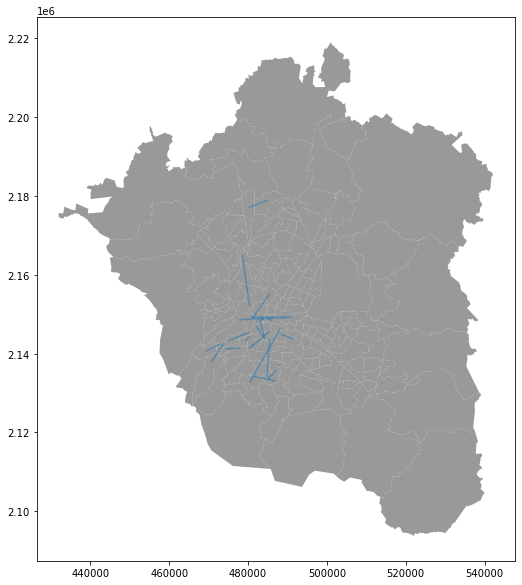

In [138]:
fig , ax = plt.subplots(1, figsize=(15,10))
zonas.plot(ax=ax, facecolor='grey', alpha=0.8)
trayectorias.loc['2014-11-26 00:00:00-06:00', '2014-11-26 06:00:00-06:00',:].plot(ax=ax, alpha=0.5)
plt.show()

Perfecto, son pocas líneas, pero es normal, es sólo un dia y de una muestra de los tuits. No todas las trayectorias van a representar a alguien yendo de un lugar a otro. Una persona sentada en su casa mandando varios tuits mientras ve la tele, también representa una trayectoria , pero esa no la queremos. Tenemos dos opciones para filtrar: por la longitud de la rayectoria o por la separación de sus puntos inicial y final. Como estamos queriendo capturar gente que _se mueve_, creo que es mejor elegir la segunda opción.

Entonces, vamos a agragar una columna con la distancia entre el inicio y fin de las trayectorias.

In [139]:
def get_start_end_distance(line):
  start = Point(line.coords[0])
  end = Point(line.coords[-1])
  return start.distance(end)

trayectorias['separation'] = trayectorias['geometry'].apply(get_start_end_distance)
trayectorias.head()

geometry  \
dia                       intervalo                 uname                                                               
2014-10-29 00:00:00-06:00 2014-10-29 10:00:00-06:00 Monnkie         LINESTRING (480572.195 2149518.998, 480632.394...   
                                                    Moon_LeyteA     LINESTRING (494153.349 2146849.292, 494155.029...   
                                                    PeRrOiMpOstOr   LINESTRING (481962.962 2146582.253, 486011.883...   
                                                    autosterra      LINESTRING (485695.505 2148735.438, 485695.092...   
                                                    germancamposmx  LINESTRING (481255.239 2149518.719, 481255.137...   

                                                                     separation  
dia                       intervalo                 uname                        
2014-10-29 00:00:00-06:00 2014-10-29 10:00:00-06:00 Monnkie           76.487081  
                                                    Moon_LeyteA        5.325912  
                                                    PeRrOiMpOstOr   4576.049807  
                                                    autosterra         9.083281  
                                                    germancamposmx     2.547196

Ahora necesitamos escoger una separación mínima para las trayectorias que vamos a considerar. De alguna forma este límite es arbitrario, pero es la distancia mínima entre origen y destino para que consideremos al movimiento como un viaje. Pensemos por lo pronto que sean 300m

In [140]:
trayectorias_filtradas = trayectorias[trayectorias['separation'] >= 300]
print(trayectorias_filtradas.shape[0], trayectorias.shape[0])

12558 87240


Terminamos con una muestra de  12,588 viajes para todo el periodo. Ahora podemos entonces calcular la matriz Origen destino

## Automatización

Todo este flujo está _empaquetado_ en la función `src/preprocess.py` que se puede utilizar así:

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.preprocess import get_trayectories
tuits_path = "../data/tuits.shp"
zones_path = "../data/DistritosEODHogaresZMVM2017.shp"
trayectorias = get_trayectories(tuits_path, zones_path, 300)
trayectorias.head()

geometry  \
dia                       intervalo                 uname                                                               
2014-10-29 00:00:00-06:00 2014-10-29 10:00:00-06:00 AlejandroSordo  LINESTRING (471865.220 2140838.487, 479166.515...   
                                                    GreenPistachio  LINESTRING (525419.137 2180731.374, 525190.231...   
                                                    MariinePa       LINESTRING (484571.596 2132370.418, 485244.847...   
                                                    PeRrOiMpOstOr   LINESTRING (490924.227 2134725.016, 481962.962...   
                          2014-10-29 14:00:00-06:00 23Tannie        LINESTRING (483439.703 2144613.319, 485053.985...   

                                                                      separation  
dia                       intervalo                 uname                         
2014-10-29 00:00:00-06:00 2014-10-29 10:00:00-06:00 AlejandroSordo   9237.812888  
                                                    GreenPistachio    669.068739  
                                                    MariinePa         738.825055  
                                                    PeRrOiMpOstOr   14826.892697  
                          2014-10-29 14:00:00-06:00 23Tannie         4788.381689

Sólo para estar seguros, repitamos el mapa

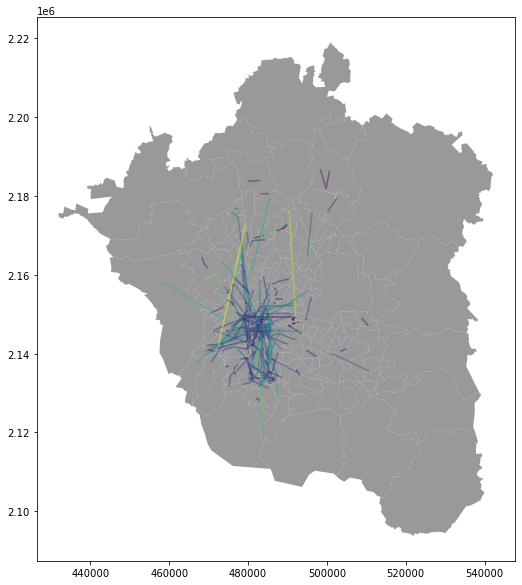

In [5]:
zonas = gpd.read_file("../data/DistritosEODHogaresZMVM2017.shp")
fig , ax = plt.subplots(1, figsize=(15,10))
zonas.plot(ax=ax, facecolor='grey', alpha=0.8)
trayectorias.loc['2014-11-26 00:00:00-06:00', '2014-11-26 06:00:00-06:00',:].plot(ax=ax, alpha=0.5, column='separation')
plt.show()

Guardamos los datos, para no tener que volverlo a correr

In [9]:
trayectorias.to_file("../output/trayectorias.gpkg", layer='trayectorias', driver="GPKG")